In [3]:
import sys
sys.path.append('..') # for import src

import os
import cloudpickle
import lzma
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
from sklearn.covariance import ledoit_wolf
import cvxpy
import joblib

import src
from src.ml_utils import (
    fetch_ohlcv, 
    visualize_result, 
    normalize_position,
    get_feature_columns,
    get_symbols,
    calc_sharpe,
    calc_max_dd,
)
cloudpickle.register_pickle_by_value(src) # for model portability


os.environ["USE_JOBLIB_MEMORY"] = "1"

def get_joblib_memory():
    if os.getenv('USE_JOBLIB_MEMORY'):
        return joblib.Memory('/tmp/alphapool_joblib_memory', verbose=0)
    else:
        return joblib.Memory(None, verbose=0)


In [2]:
!pip install universal-portfolios riskparityportfolio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 36.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.5/215.5 kB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 33.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 38.5 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11431 sha256=83aa54e6da6b7c8fc063ab2e35fbb60a424deba9283c724d0381d259c5aa588b
  Stored in directory: /home/jovyan/.cache/pip/wheels/21/0a/27/62f77273aa12fefb20b9b277f1e937f98ae16dbd04ffa2b93a
Successfully built retrying
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.3.0
    Uninstalling typing_extensions-4.3.0:
      Successfully uninstalled typing_extensions-4.3.0
  Attempting uninstall: seaborn
  

In [4]:
from universal.algos import UP, EG, RMR, Anticor

class MyUP(UP):
    def init_step(self, X):
        rs = np.random.RandomState(1)
        m = X.shape[1]
        self.W = rs.dirichlet(np.ones(m) * 1.0, 10000)
        self.S = np.matrix(np.ones(self.W.shape[0])).T

class UniversalPortfolio:    
    def predict(self, df):
        df_x = df.reset_index().pivot(
            index='timestamp',
            columns='model_id',
            values='ret'
        ).fillna(0)
        
        # algo = UP()
        algo = MyUP()
        # algo = EG(
            # eta=0.01,
            # eta=0.05,
            # eta=0.5,
        # )
        # algo = RMR()
        # algo = Anticor()
        
        
        df_x = np.maximum(0.1, 1 + df_x * 1).cumprod()
        result = algo.run(df_x)
        df_weight = result._B

        df2 = df_weight.stack()
        df['position'] = df2.loc[df.index].fillna(0)
        
        df2 = df.copy()
        df2["position_abs"] = df2["position"].abs() * (df2['ret'].rolling(12, 1).mean() != 0)
        df["position"] /= 1e-37 + df2.groupby("timestamp")["position_abs"].transform("sum")

        # normalize_position(df)
        return df['position']
    

In [6]:
import riskparityportfolio as rp


class ExampleModelPortfolio:
    def __init__(self):
        self.max_data_sec = 2 * 30 * 24 * 60 * 60 # for predict script 
    
    def fit(self, df):
        self.symbols = get_symbols(df) # for predict script 
    
    def predict(self, df):
        df_x = df.reset_index().pivot(
            index='timestamp',
            columns='model_id',
            values='ret'
        ).fillna(0)
        
        mu_len = 12 * 24 * 60
        cov_len = 12 * 24 * 60
        
        df_weight = df_x.copy() * 0
        for i in range(1, df_x.shape[0]):
            if not (df_x.index[i].hour % 1 == 0 and df_x.index[i].minute == 0):
                continue
            print(i)
                
            max_i = i - 1

            df_cov = df_x.iloc[max(0, max_i - cov_len + 1):max_i + 1]
            S, _ = ledoit_wolf(df_cov)  
            
            mu = df_x.iloc[max(0, max_i - mu_len + 1):max_i + 1].mean(axis=0)

            # weight = optimize_mv(
            #     mu=mu, 
            #     S=S, 
            #     target_std=0.04 / (24 ** 0.5), 
            #     # max_total_pos=1.0
            # )
            weight = 1.0 / df_cov.replace(0, np.nan).std()
            # weight = 1.0 / np.diag(S) ** 0.5
            # weight = rp.vanilla.design(S, np.ones(S.shape[0]))
            df_weight.iloc[i, :] = weight
            
        df_weight = df_weight.rolling(12 * 2, 1).mean()
        
        df2 = df_weight.stack()
        df['position'] = df2.loc[df.index].fillna(0)
        
        normalize_position(df)
        return df['position']
    
def optimize_mv(mu=None, S=None, target_std=None, max_total_pos=None):
    mem = get_joblib_memory()
    return mem.cache(do_optimize_mv)(mu=mu, S=S, target_std=target_std, max_total_pos=max_total_pos)

def do_optimize_mv(mu=None, S=None, target_std=None, max_total_pos=None):
    x = cvxpy.Variable(mu.shape[0])
    S = np.array(S)
    mu = np.array(mu)

    objective = cvxpy.Minimize(-mu @ x)
    constraints = [
        cvxpy.quad_form(x, S) <= target_std ** 2,
        x >= 0,
    ]
    
    if max_total_pos is not None:
        constraints += [
            cvxpy.sum(cvxpy.abs(x)) <= max_total_pos,
        ]

    prob = cvxpy.Problem(objective, constraints)

    try:
        result = prob.solve()
        weight = x.value
        if weight is None:
            print('weight is None')
            weight = np.zeros(mu.size)
    except Exception as e:
        print(e)
        weight = np.zeros(mu.size)

    return weight

In [9]:
def visualize_result(df, symbol_col='symbol', execution_cost=0.001):
    df = df.copy()

    # calc return
    df["ret_pos"] = df["ret"] * df["position"]
    df["hour"] = df.index.get_level_values("timestamp").hour
    df["position_prev"] = df.groupby(["hour", symbol_col])["position"].shift(1).fillna(0)
    df["cost"] = (df["position"] - df["position_prev"]).abs() * execution_cost
    df["ret_pos_cost"] = df["ret_pos"] - df["cost"]

    # print statistics
    for with_cost in [False, True]:
        if with_cost:
            print("return with cost statistics")
            x = df.groupby("timestamp")["ret_pos_cost"].sum()
        else:
            print("return without cost statistics")
            x = df.groupby("timestamp")["ret_pos"].sum()

        print("mean {}".format(np.mean(x)))
        print("std {}".format(np.std(x)))
        print("sharpe {}".format(calc_sharpe(x)))
        print("max drawdown {}".format(calc_max_dd(x)))

    # plot ret
    for symbol, df_symbol in df.groupby(symbol_col):
        df_symbol = df_symbol.reset_index().set_index("timestamp")
        # df_symbol["ret"].cumsum().plot(label=symbol)
        df_symbol["ret_pos"].cumsum().iloc[::12].plot(label=symbol)
        # df_symbol["ret_pos_cost"].cumsum().plot(label=symbol)
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.title("return with cost by symbol")
    plt.show()

    # plot position
    for symbol, df_symbol in df.groupby(symbol_col):
        df_symbol = df_symbol.reset_index().set_index("timestamp")
        df_symbol["position"].iloc[::12].plot(label=symbol)
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.title("position by symbol")
    plt.show()

    # plot total ret
    df.groupby("timestamp")["ret_pos"].sum().cumsum().iloc[::12].plot(label="ret without cost")
    # df.groupby("timestamp")["ret_pos_cost"].sum().cumsum().plot(label="ret with cost")
    # df.groupby("timestamp")["cost"].sum().cumsum().plot(label="cost")
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.title("total return")
    plt.show()


ret
timestamp                 model_id                         
2022-09-01 16:05:00+00:00 example-model-portfolio -0.000031
                          example-model-rank      -0.000054
                          example-model-rank2      0.000000
                          example-model-rank3      0.000000
                          m-20220904-nn            0.000000
...                                                     ...
2022-10-28 03:55:00+00:00 m-20221020-rank-nn      -0.001578
                          m-20221028-btc-one-h4    0.003494
                          pf-universal             0.000134
                          pf-universal2            0.000355
                          pf-universal2-high       0.000731

[520114 rows x 1 columns]

11
23
35
47
59
71
83
95
107
119
131
143
155
167
179
191
203
215
227
239
251
263
275
287
299
311
323
335
347
359
371
383
395
407
419
431
443
455
467
479
491
503
515
527
539
551
563
575
587
599
611
623
635
647
659
671
683
695
707
719
731
743
755
767
779
791
803
815
827
839
851
863
875
887
899
911
923
935
947
959
971
983
995
1007
1019
1031
1043
1055
1067
1079
1091
1103
1115
1127
1139
1151
1163
1175
1187
1199
1211
1223
1235
1247
1259
1271
1283
1295
1307
1319
1331
1343
1355
1367
1379
1391
1403
1415
1427
1439
1451
1463
1475
1487
1499
1511
1523
1535
1547
1559
1571
1583
1595
1607
1619
1631
1643
1655
1667
1679
1691
1703
1715
1727
1739
1751
1763
1775
1787
1799
1811
1823
1835
1847
1859
1871
1883
1895
1907
1919
1931
1943
1955
1967
1979
1991
2003
2015
2027
2039
2051
2063
2075
2087
2099
2111
2123
2135
2147
2159
2171
2183
2195
2207
2219
2231
2243
2255
2267
2279
2291
2303
2315
2327
2339
2351
2363
2375
2387
2399
2411
2423
2435
2447
2459
2471
2483
2495
2507
2519
2531
2543
2555
2567
2579
2591
2603
2615
2

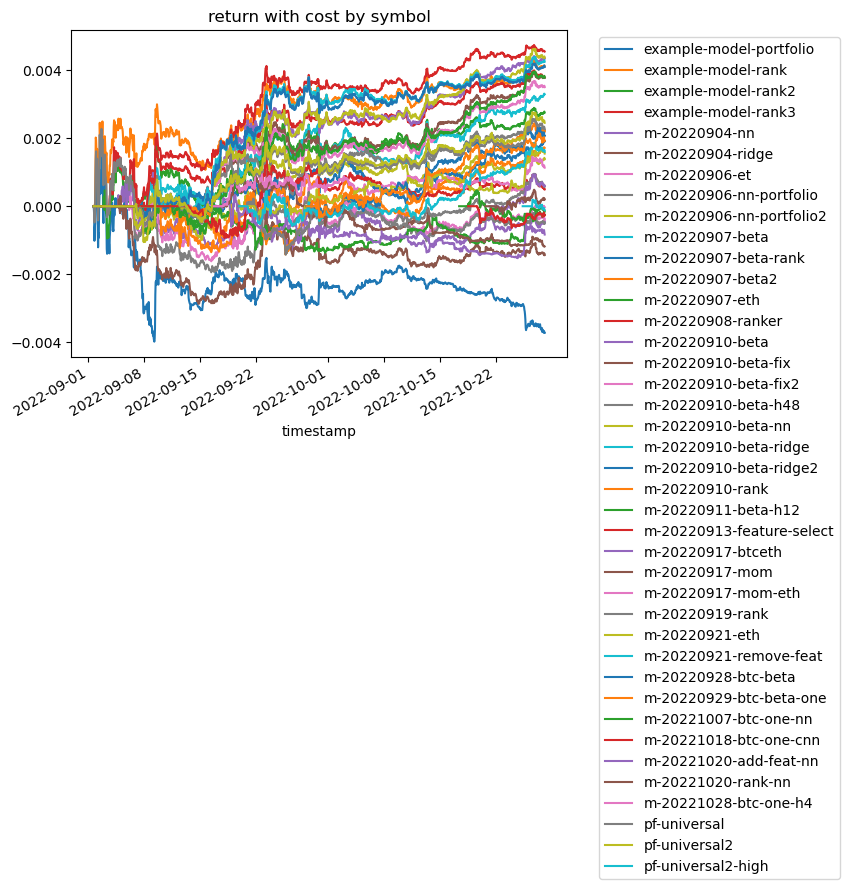

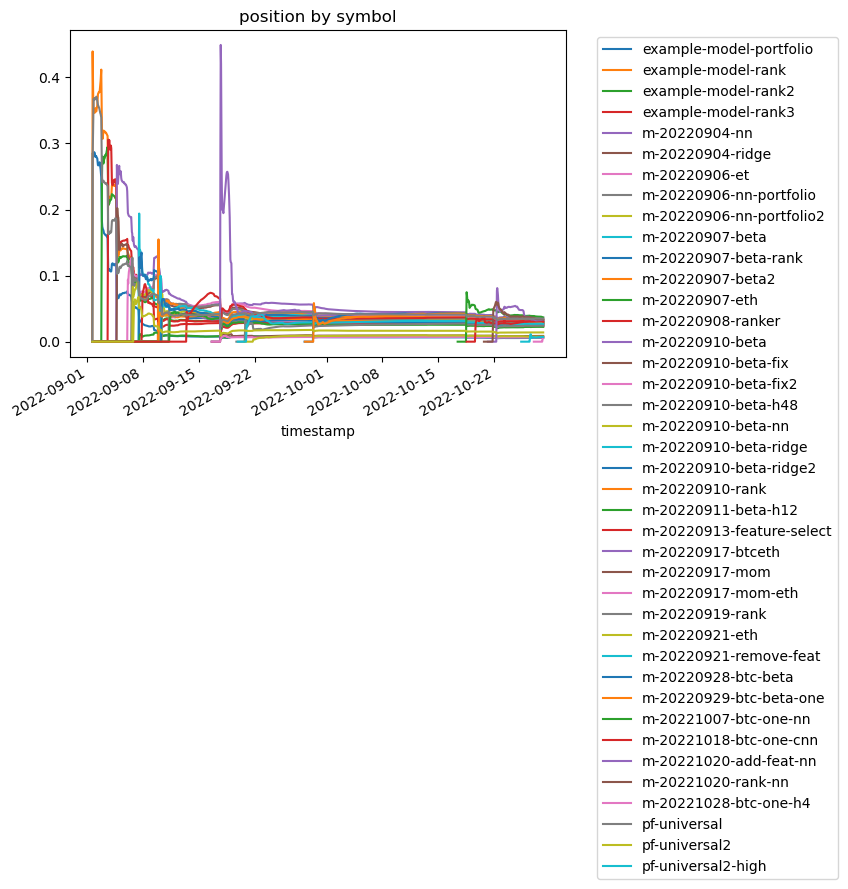

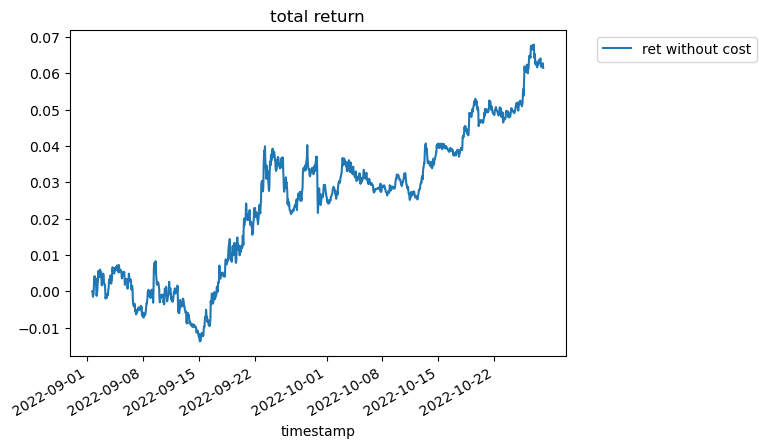

In [10]:
# df = pd.read_parquet('/home/jovyan/data/20220930_returns.parquet')
df = pd.read_parquet('/home/jovyan/data/20221028_returns.parquet')
display(df)

model = ExampleModelPortfolio()
# model = UniversalPortfolio()

df['pos'] = model.predict(df)
visualize_result(df.dropna(), symbol_col='model_id')